In [1]:
import pandas as pd
import random
import numpy as np
import sklearn as sk
from scipy import stats
import statistics
import cvxpy as cvx
import xgboost
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
xgboost.__version__
from scipy.linalg import svd
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import math
from multiprocessing import  Pool

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_name = './compas-scores-two-years.csv'
full_data = pd.read_csv(file_name)
full_data.race.value_counts()

print(full_data.shape)

# remove groups with few instances 
full_data = full_data.query("race != 'Asian'").query("race != 'Native American'")

# group by felony or misdemenor charge
full_data.groupby(['c_charge_degree','is_recid'])['id'].count().reset_index()

# turn charge degree to numbers 
full_data['c_charge_degree'] = pd.Categorical(full_data['c_charge_degree'])
# change numbers into dummies (1 for present 0 for absent)
dummies = pd.get_dummies(full_data['c_charge_degree'], prefix='charge')
full_data = pd.concat([full_data, dummies], axis=1)

# remove bad data
full_data = full_data.query("days_b_screening_arrest <= 30") \
        .query("days_b_screening_arrest >= -30")\
        .query("is_recid != -1")\
        .query("c_charge_degree != 'O'") \
        .query("score_text != 'N/A'" )\
        .query("race != 'Asian'")\
        .query("race != 'Native American'")\
        .query("race != 'Other'")\
        .query("race != 'Hispanic'")

print(full_data.shape)

# randomize race for later use
full_data['race_random'] = np.random.permutation(full_data['race'])

# check how many random to the same thing
np.sum(full_data['race']==full_data['race_random'])

# check counts of recidivism by race
full_data.groupby(['race','is_recid'])['id'].count().reset_index()

# keep relevant columns 
columns_kept = ['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'priors_count', 'c_charge_degree', \
                'is_recid', 'decile_score', 'two_year_recid', 'c_jail_in', 'c_jail_out', 'race_random', \
                'charge_F', 'charge_M', 'score_text', 'id']
full_data = full_data.loc[:, columns_kept]

full_data = full_data.set_index('id')

full_data.head()

(7214, 53)
(5278, 55)


,sex,age,age_cat,race,juv_fel_count,priors_count,c_charge_degree,is_recid,decile_score,two_year_recid,c_jail_in,c_jail_out,race_random,charge_F,charge_M,score_text
id,,,,,,,,,,,,,,,,
3,Male,34,25 - 45,African-American,0,0,F,1,3,1,2013-01-26 03:45:27,2013-02-05 05:36:53,African-American,1,0,Low
4,Male,24,Less than 25,African-American,0,4,F,1,4,1,2013-04-13 04:58:34,2013-04-14 07:02:04,Caucasian,1,0,Low
8,Male,41,25 - 45,Caucasian,0,14,F,1,6,1,2014-02-18 05:08:24,2014-02-24 12:18:30,Caucasian,1,0,Medium
10,Female,39,25 - 45,Caucasian,0,0,M,0,1,0,2014-03-15 05:35:34,2014-03-18 04:28:46,African-American,0,1,Low
14,Male,27,25 - 45,Caucasian,0,0,F,0,4,0,2013-11-25 06:31:06,2013-11-26 08:26:57,African-American,1,0,Low


In [3]:
learning_data = full_data.copy(deep=True)
features_to_transform = ['age_cat', 'sex', 'race', 'c_charge_degree']

for feature in features_to_transform:
    dummies = pd.get_dummies(learning_data[feature], prefix=feature)
    learning_data = pd.concat([learning_data, dummies], axis = 1)
learning_data.head()

learning_data.columns = learning_data.columns.str.replace('-', '_')

learning_data['score_factor'] = np.where(learning_data['score_text'] == 'Low', 'Low', 'MediumHigh')
dummies = pd.get_dummies(learning_data['score_factor'])
learning_data = pd.concat([learning_data, dummies] , axis = 1)
learning_data.head()

,sex,age,age_cat,race,juv_fel_count,priors_count,c_charge_degree,is_recid,decile_score,two_year_recid,...,age_cat_Less than 25,sex_Female,sex_Male,race_African_American,race_Caucasian,c_charge_degree_F,c_charge_degree_M,score_factor,Low,MediumHigh
id,,,,,,,,,,,,,,,,,,,,,
3,Male,34,25 - 45,African-American,0,0,F,1,3,1,...,0,0,1,1,0,1,0,Low,1,0
4,Male,24,Less than 25,African-American,0,4,F,1,4,1,...,1,0,1,1,0,1,0,Low,1,0
8,Male,41,25 - 45,Caucasian,0,14,F,1,6,1,...,0,0,1,0,1,1,0,MediumHigh,0,1
10,Female,39,25 - 45,Caucasian,0,0,M,0,1,0,...,0,1,0,0,1,0,1,Low,1,0
14,Male,27,25 - 45,Caucasian,0,0,F,0,4,0,...,0,0,1,0,1,1,0,Low,1,0


In [4]:
X_Labels = ['sex_Male', 'age', 'race_African_American', 'race_Caucasian', 'priors_count',\
            'juv_fel_count', 'c_charge_degree_F', 'c_charge_degree_M']
Y_Labels = ['Low']


X =  learning_data.loc[:, X_Labels]
Y =  learning_data.loc[:, Y_Labels]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =  0.2, random_state =  4)

# find and later remove linearly correlated pairs (not for xgboost but for LOCO later)
corr_thresh = .7
for column_a in X.columns:
    for column_b in X.columns:
        if column_a is not column_b:
            if X[column_a].corr(X[column_b]) > corr_thresh:
                print(column_a + " " + column_b)
    

xgb_full = xgboost.DMatrix(X, label=Y)
xgb_train =  xgboost.DMatrix(X_train, label = Y_train)
xgb_test = xgboost.DMatrix(X_test, label = Y_test)
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"auc",
    "tree_method": 'gpu_hist',
    "subsample": 0.5
}
#model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
model = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params,xgb_full, nfold = 3, metrics="auc" , num_boost_round=10)
learning_data['pred'] = model.predict(xgb_full)


[0]	test-auc:0.80809
[1000]	test-auc:0.83846
[2000]	test-auc:0.83932
[3000]	test-auc:0.83820
[4000]	test-auc:0.83604
[5000]	test-auc:0.83403
[6000]	test-auc:0.83267
[7000]	test-auc:0.83148
[8000]	test-auc:0.83018
[9000]	test-auc:0.82911
[9999]	test-auc:0.82770


In [5]:
plt.hist(learning_data['pred'], bins = 20)
plt.show()

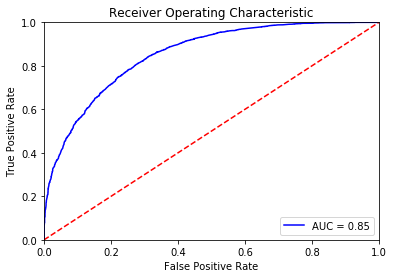

Optimal Threshold obtained using difference of TPR and FPR 0.52095777


In [6]:
%matplotlib inline
fpr, tpr , thresholds = roc_curve(learning_data['Low'], learning_data['pred'])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
learning_data['y_pred'] = np.where(learning_data['pred'] > optimal_threshold, 1, 0)

## Find Burden

In [7]:

class CounterFactFactory:
    # do we need to mutate catagorical and continous data seperately? 
    # we probably need to ask for some bounds on each feature

    # bounds is a dict with form {<feature_name>: (<"catagorical"/"continous">, <number catagories/continous scale>)}
    # continous scale is max value for generating the initial population continous features
    # -(continous scale) is min value for generating the initial population
    def __init__(self, indiv, model_pred_func, bounds, fit_func, 
               selection_rate=.5, prob_mut=.2, prob_cross=.5, init_pop_size=1000,
               round_func=np.around, generations=200, stall_eps=.001, min_iter=5,
               random_state=None,
                 **kwargs):
        self.index = indiv['id']
        self.model_pred_func = model_pred_func  # f(x)
        self.indiv = indiv.drop('id', axis=1)   # x
        self.c_fact_list = pd.DataFrame()       # subset of I
        self.feature_bounds = bounds            # may be used for mutation
        self.fitness = fit_func                 # d(x, c)
        self.pop_size = init_pop_size
        self.round_func = round_func
        self.p_s = selection_rate
        self.p_m = prob_mut
        self.p_c = prob_cross
        self.indiv_class = self.round_func(self.model_pred_func(xgboost.DMatrix(self.indiv)))
        self.indiv_class = self.indiv_class[0]
        self.gen = generations
        self.stall_eps = stall_eps
        self.stall_time = min_iter
        
        
        self.catL = [] 
        self.conL = []
        self.feature_names =  []
        
        np.random.seed(random_state)
        
        for feature_name in self.feature_bounds:
            bounds = self.feature_bounds[feature_name]
            self.feature_names.append(feature_name)
            if bounds[0].startswith("cat"):
                self.catL.append(feature_name)
            elif bounds[0].startswith("cont"):
                self.conL.append(feature_name)
            else:
                print("error in bounds dictionary")
                print("expected catagorical or continous and got neither")
                raise ValueError()



    # step 7
    def genRandomCFactuals(self):
        
        temp = None
        if not self.c_fact_list.empty:
            temp = self.c_fact_list.columns
            
        # keep generating counter factuals until our population is up to size
        while self.c_fact_list.shape[0] < self.pop_size:
            # generate new individuals
            new_indivs = pd.DataFrame()
            for feature_name in self.feature_names:
                bounds = self.feature_bounds[feature_name]
                if bounds[0].startswith("cat"):
                    # catagorical random
                    new_indivs[feature_name] = np.random.randint(0, bounds[1], size=self.pop_size-self.c_fact_list.shape[0])
                elif bounds[0].startswith("cont"):
                    # continous random
                    new_indivs[feature_name] = np.random.rand(self.pop_size-self.c_fact_list.shape[0], 1) * (bounds[1])
                else:
                    print("error in bounds dictionary")
                    print("expected catagorical or continous and got neither")
            # calculate new predictions and filter
            new_indivs['prediction'] = new_indivs.apply(lambda row : 
                                                      self.round_func(self.model_pred_func(xgboost.DMatrix(pd.DataFrame(row).T)))[0],
                                                      axis = 1)
            new_indivs = new_indivs[new_indivs.prediction != self.indiv_class]

            # add the survivors to the dataframe
            if temp is None:
                temp = new_indivs.columns
                
            self.c_fact_list = pd.concat([self.c_fact_list, new_indivs], axis=0)
            self.c_fact_list = self.c_fact_list[temp]
            
    # step 8
    def selection(self):
        if self.c_fact_list is pd.DataFrame.empty:
            print("attempted to select on an empty population")
            print("try calling genRandomCFactuals first?")
            print("if this appears from a call of getCFactuals then its a bug. please report it")
            return

        # sort by fitness and then keep the top half
        self.c_fact_list['fitness'] = self.c_fact_list.apply(lambda row : 
                                                             self.fitness(self.indiv, row, self.catL, self.conL),
                                                             axis=1)
        self.c_fact_list = (self.c_fact_list.loc[self.c_fact_list.fitness.sort_values(ascending=False).index
                                                 ])[:int(self.c_fact_list.shape[0]*self.p_s)]

    # step 9
    def mutation(self):
        # get individuals to mutate
        to_mut_indivs = self.c_fact_list.sample(frac=self.p_m, axis=0)

        # mutate the individuals
        for feature_name in self.feature_names:
            bounds = self.feature_bounds[feature_name]
            if bounds[0].startswith("cat"):
                # catagorical random
                self.c_fact_list.loc[to_mut_indivs.index, feature_name] = np.random.randint(0, bounds[1], size=to_mut_indivs.shape[0])
            elif bounds[0].startswith("cont"):
                # continous random
                self.c_fact_list.loc[to_mut_indivs.index, feature_name] = np.random.rand(to_mut_indivs.shape[0], 1) * (bounds[1])
            else:
                print("error in bounds dictionary")
                print("expected catagorical or continous and got neither")

          

        # set the counter factuals to their mutated version
        self.c_fact_list.loc[to_mut_indivs.index] = to_mut_indivs

        # recalculate the predictions
        self.c_fact_list.drop('prediction', inplace=True, axis=1)
        self.c_fact_list.drop('fitness', inplace=True, axis=1)
        self.c_fact_list['prediction'] = self.c_fact_list.apply(lambda row : 
                                                self.round_func(self.model_pred_func(xgboost.DMatrix(pd.DataFrame(row).T)))[0],
                                                axis = 1)
        
        # recalculate the fitnesses for use later
        self.c_fact_list['fitness'] = self.c_fact_list.apply(lambda row : 
                                                             self.fitness(self.indiv, row, self.catL, self.conL),
                                                             axis = 1)

    # step 10
    def crossover(self):
        # make sure to recalculate the fitnesses, and predictions
        # make sure to filter out
        # idea: 
        #1. sort by fitness, and keep top p_c portion. 
        #2. cross over between c_0 & c_1, c_2 & c_3, and so on
        #3. to cross over, swap each feature value with 50% probability
        self.c_fact_list['fitness'] = self.c_fact_list.apply(lambda row : 
                                                             self.fitness(self.indiv, row, self.catL, self.conL),
                                                             axis = 1)
        self.c_fact_list = (self.c_fact_list.loc[self.c_fact_list.fitness.sort_values(ascending=False).index])
        self.c_fact_list.drop('prediction', inplace=True, axis=1)
        self.c_fact_list.drop('fitness', inplace=True, axis=1)
        
        count = self.c_fact_list.shape[0] * self.p_c
        i = 0
        while i < count:
            for feature_name in self.feature_bounds:
                if(np.random.random_sample() > 0.5):
                    old_val = self.c_fact_list.loc[i, feature_name]
                    self.c_fact_list.loc[i, feature_name] = self.c_fact_list.loc[i+1, feature_name]
                    self.c_fact_list.loc[i, feature_name] = old_val
            i = i + 2
        pass
    
        self.c_fact_list['prediction'] = self.c_fact_list.apply(lambda row : 
                                        self.round_func(self.model_pred_func(xgboost.DMatrix(pd.DataFrame(row).T)))[0],
                                        axis = 1)

        # recalculate the fitnesses for use later
        self.c_fact_list['fitness'] = self.c_fact_list.apply(lambda row : 
                                                             self.fitness(self.indiv, row, self.catL, self.conL),
                                                             axis = 1)


    # step 11
    def filterCFacts(self):
        # filter the population of counter factuals (self.c_fact_list) to remove all
        # individuals that have the same prediction class (self.indiv_class) as the original 
        # individual (self.indiv)
        self.c_fact_list = self.c_fact_list[self.c_fact_list.prediction != self.indiv_class]
        pass

    def getMaxCFact(self):
        return self.c_fact_list[self.c_fact_list.fitness == self.c_fact_list.fitness.max(), :]
    
    # step 12
    def getCFactuals(self):
        max_list = []
        
        for generation in range(self.gen):
            self.genRandomCFactuals()
            self.c_fact_list.reset_index(drop=True, inplace=True)
            
            self.selection()
            self.c_fact_list.reset_index(drop=True, inplace=True)
            
            self.mutation()
            self.c_fact_list.reset_index(drop=True, inplace=True)

            self.crossover()
            self.c_fact_list.reset_index(drop=True, inplace=True)

            self.filterCFacts()
            self.c_fact_list.reset_index(drop=True, inplace=True)
            
            max_list.append(self.c_fact_list.fitness.max())
                        
            if len(max_list) > self.stall_time and (np.array(max_list)[-self.stall_time:] == max_list[-1]).sum() >= self.stall_time :
                print("stalled out on generation", generation,
                      "with max fitness", self.c_fact_list.fitness.max())
                retval = self.c_fact_list[self.c_fact_list.fitness == self.c_fact_list.fitness.max()]
                retval.index = self.index
                return retval
            
            if(generation == self.gen-1):
                print("Generation", generation, "with max fitness", self.c_fact_list.fitness.max())
            
        retval = self.c_fact_list[self.c_fact_list.fitness == self.c_fact_list.fitness.max()]
        retval.index = self.index
        return retval

In [8]:
def d(indiv, other, cat, con):
    
    agg = pd.DataFrame(indiv)
    agg.loc[1] = other
    agg.reset_index(drop=True, inplace=True)
    
    ncat = len(cat)
    ncon = len(con)
    
    xcat = agg.loc[:, cat]
    xcon = agg.loc[:, con]
        
    # MAD normalized L1 Norm
    normedl1norm = 0
    for feature in con:
        mad = madArray[feature]
        normedl1norm += abs(xcon.iloc[0,:].loc[feature] - xcon.iloc[1,:].loc[feature]) / mad

        
    # simpMat
    # both pos
    xcat = xcat.astype('int32')
    PosMat = xcat.loc[0] & xcat.loc[1] 
    NegMat = (1 - xcat.loc[0]) & (1 - xcat.loc[1])
    total = xcat.shape[1]
    dist = (PosMat.sum() + NegMat.sum())/total
    
    n = ncat + ncon
    return ncon*normedl1norm/n + ncat*dist/n

In [9]:
import multiProcFuncs

def parallelize_dataframe(df, func, n_cores=4, cb=None):
    pool = Pool(n_cores)
    futures = [pool.apply_async(func, args=fact, callback=cb) for fact in df]
    print("done dispatching workers")
    fragments = [x.get() for x in futures]
    ret = pd.concat(fragments)
    pool.close()
    pool.join()
    return ret

In [ ]:

b = {
    'sex_Male':   ("catagorical", 2),
    'age':        ("continous", 100),
    'race_African_American': ("catagorical", 2),
    'race_Caucasian': ("catagorical", 2),
    'priors_count':   ("continous", 100),
    'juv_fel_count':  ("continous", 100),
    'c_charge_degree_F': ("catagorical", 2),
    'c_charge_degree_M': ("catagorical", 2)
}

cdf = pd.DataFrame(columns=['fitness']+X_Labels)
burden_data = learning_data.loc[:, X_Labels]
burden_data['id'] = burden_data.index

madArray = {}
for feature in b:
    bounds = b[feature]
    if bounds[0].startswith("cont"):
        madArray[feature] = burden_data.loc[:, feature].mad()

def inv_dist(ind, otr, cat, con):
    return 1 / d(ind, otr, cat, con)    

facts = burden_data.apply(lambda row: 
                          CounterFactFactory(indiv=pd.DataFrame(row).T, model_pred_func=model.predict, bounds=b, 
                            fit_func=inv_dist, init_pop_size=5, generations=5, random_state=4,
                            min_iter=1),
                          axis=1)

print("done creating factories")
temp = parallelize_dataframe(facts, multiProcFuncs.unpack_factory, 5, multiProcFuncs.callback_func)

print(temp)

cdf = cdf.append(final_c_fact)

cdf.head()

done creating factories
done dispatching workers


In [ ]:
burden_data['fitness'] = cdf.fitness
burden_data.head()

In [ ]:
print("African American Burden: ", (burden_data[burden_data['race_African_American'] == 1].fitness).mean())
print("Caucasian Burden: ", (burden_data[burden_data['race_Caucasian'] == 1].fitness).mean())


In [ ]:
from datetime import datetime

cdf.to_pickle("./compas_cfact_" + datetime.now().strftime("%m_%d_%Y_%H_%M") +".pkle")

In [22]:
from collections import namedtuple

class Model:
    
    def __init__(self, datadf, cfdf):
        self.pred = datadf['pred'].copy()
        self.label = datadf['Low'].copy()
        self.datadf = datadf.copy()
        self.cfdf = cfdf.copy()
        self.datadf['cfact_dist'] = 1/cfdf['fitness']
        self.datadf = self.datadf.query("cfact_dist == cfact_dist")
                    
    def logits(self):
        raw_logits = np.clip(np.log(self.pred / (1 - self.pred)), -100, 100)
        return raw_logits

    def num_samples(self):
        return len(self.pred)

    def base_rate(self):
        """
        Percentage of samples belonging to the positive class
        """
        return np.mean(self.label)

    def accuracy(self):
        return self.accuracies().mean()

    def precision(self):
        return (self.label[self.pred.round() == 1]).mean()

    def recall(self):
        return (self.label[self.label == 1].round()).mean()

    def tpr(self):
        """
        True positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 1))

    def fpr(self):
        """
        False positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 0))

    def tnr(self):
        """
        True negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 0))

    def fnr(self):
        """
        False negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 1))

    def fn_cost(self):
        """
        Generalized false negative cost
        """
        return 1 - self.pred[self.label == 1].mean()

    def fp_cost(self):
        """
        Generalized false positive cost
        """
        return self.pred[self.label == 0].mean()

    def accuracies(self):
        return self.pred.round() == self.label
    
    def get_burden(self):
        return self.datadf['cfact_dist'].mean()

    def burden_eq_opp(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
                   
        # find indices close to the border and flip them
        if self.get_burden() > othr.get_burden():
            burdened_predictor = "self"
        else:
            burdened_predictor = "other"
        
        if burdened_predictor is "self":
            priv_df = self.datadf.copy()
            disa_df = othr.datadf.copy()
            priv_p2n = 1 - sp2p[0]
            dis_n2p = on2p[0]
        else:
            priv_df = othr.datadf.copy()
            disa_df = self.datadf.copy()
            priv_p2n = 1 - op2p[0]
            dis_n2p = sn2p[0]
                
        priv_pos = priv_df[priv_df['y_pred'] == 1]
        dis_neg = disa_df[disa_df['y_pred'] == 0]
        
        priv_ind = priv_pos.id.sample(frac=priv_p2n)
        disa_ind = dis_neg.id.sample(frac=dis_n2p)

        priv_df.loc[priv_ind, "pred"] = 1 - priv_df.loc[priv_ind, "pred"]
        disa_df.loc[disa_ind, "pred"] = 1 - disa_df.loc[disa_ind, "pred"]

        fair_self = None
        fair_othr = None
                
        if burdened_predictor is "self":
            fair_self = Model(priv_df, self.cfdf)
            fair_othr = Model(disa_df, othr.cfdf)
        else:
            fair_self = Model(disa_df, self.cfdf)
            fair_othr = Model(priv_df, othr.cfdf)
                
        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr
    
    def burden_eq_odds(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
                   
        # find indices close to the border and flip them
        if self.get_burden() > othr.get_burden():
            burdened_predictor = "self"
        else:
            burdened_predictor = "other"
        
        if burdened_predictor is "self":
            priv_df = self.datadf
            disa_df = othr.datadf
        else:
            priv_df = othr.datadf
            disa_df = self.datadf
        
        self_df = self.datadf.copy(deep=True)
        self_df_pos = self_df[self_df["y_pred"] == 1]
        self_df_neg = self_df[self_df["y_pred"] == 0]
        othr_df = othr.datadf.copy(deep=True)
        othr_df_pos = othr_df[othr_df["y_pred"] == 1]
        othr_df_neg = othr_df[othr_df["y_pred"] == 0]
    
            
        num_sn2p = int(self_df.shape[0] *  (sn2p[0]))
        sn2p_indices = np.asarray(self_df_neg.sort_values('cfact_dist', ascending = True).id)[:num_sn2p]
        
        num_on2p = int(othr_df.shape[0] *  (on2p[0]))
        on2p_indices = np.asarray(othr_df_neg.sort_values('cfact_dist', ascending = True).id)[:num_on2p]
        
        num_sp2n = int(self_df.shape[0] *  (1 - sp2p[0]))
        sp2n_indices = np.asarray(self_df_pos.sort_values('cfact_dist', ascending = True).id)[:num_sp2n]
        
        num_op2n = int(othr_df.shape[0] *  (1 - op2p[0]))
        op2n_indices = np.asarray(othr_df_pos.sort_values('cfact_dist', ascending = True).id)[:num_op2n]

        
        # flip those values
        self_df.loc[sn2p_indices, 'pred'] = 1 - self_df.loc[sn2p_indices, 'pred']      
        self_df.loc[sp2n_indices, 'pred'] = 1 - self_df.loc[sp2n_indices, 'pred']      

        othr_df.loc[on2p_indices, 'pred'] = 1 - othr_df.loc[on2p_indices, 'pred']
        othr_df.loc[op2n_indices, 'pred'] = 1 - othr_df.loc[op2n_indices, 'pred']      
        
        fair_self = Model(self_df, self.cfdf)
        fair_othr = Model(othr_df, othr.cfdf)

        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr
        
    def eq_odds(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
        
        # select random indices to flip in our model
        self_fair_pred = self.datadf.copy()
        self_pp_indices = self_fair_pred[self_fair_pred["pred"] >= .5]
        self_pn_indices = self_fair_pred[self_fair_pred["pred"] < .5]
        self_pp_indices = self_pp_indices.sample(frac=(1-sp2p[0]))
        self_pn_indices = self_pn_indices.sample(frac=sn2p[0])
        
        # flip randomly the predictions in our model
        self_fair_pred.loc[self_pn_indices.id] = 1 - self_fair_pred.loc[self_pn_indices.id]
        self_fair_pred.loc[self_pp_indices.id] = 1 - self_fair_pred.loc[self_pp_indices.id]

        # select random indices to flip in the other model
        othr_fair_pred = othr.datadf.copy()
        othr_pp_indices = othr_fair_pred[othr_fair_pred["pred"] >= .5]
        othr_pn_indices = othr_fair_pred[othr_fair_pred["pred"] < .5]
        othr_pp_indices = othr_pp_indices.sample(frac=(1-op2p[0]))
        othr_pn_indices = othr_pn_indices.sample(frac=on2p[0])

        # dlip randomly the precitions of the other model
        othr_fair_pred.loc[othr_pn_indices.id] = 1 - othr_fair_pred.loc[othr_pn_indices.id]
        othr_fair_pred.loc[othr_pp_indices.id] = 1 - othr_fair_pred.loc[othr_pp_indices.id]

        # create new model objects with the now fair predictions
        
        fair_self = Model(self_fair_pred, self.cfdf)
        fair_othr = Model(othr_fair_pred, othr.cfdf)

        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr   
        
        
    def eq_odds_optimal_mix_rates(self, othr):
        sbr = float(self.base_rate())
        obr = float(othr.base_rate())

        sp2p = cvx.Variable(1)
        sp2n = cvx.Variable(1)
        sn2p = cvx.Variable(1)
        sn2n = cvx.Variable(1)

        op2p = cvx.Variable(1)
        op2n = cvx.Variable(1)
        on2p = cvx.Variable(1)
        on2n = cvx.Variable(1)

        sfpr = self.fpr() * sp2p + self.tnr() * sn2p
        sfnr = self.fnr() * sn2n + self.tpr() * sp2n
        ofpr = othr.fpr() * op2p + othr.tnr() * on2p
        ofnr = othr.fnr() * on2n + othr.tpr() * op2n
        error = sfpr + sfnr + ofpr + ofnr

        sflip = 1 - self.pred
        sconst = self.pred
        oflip = 1 - othr.pred
        oconst = othr.pred

        sm_tn = np.logical_and(self.pred.round() == 0, self.label == 0)
        sm_fn = np.logical_and(self.pred.round() == 0, self.label == 1)
        sm_tp = np.logical_and(self.pred.round() == 1, self.label == 1)
        sm_fp = np.logical_and(self.pred.round() == 1, self.label == 0)

        om_tn = np.logical_and(othr.pred.round() == 0, othr.label == 0)
        om_fn = np.logical_and(othr.pred.round() == 0, othr.label == 1)
        om_tp = np.logical_and(othr.pred.round() == 1, othr.label == 1)
        om_fp = np.logical_and(othr.pred.round() == 1, othr.label == 0)

        spn_given_p = (sn2p * (sflip * sm_fn).mean() + sn2n * (sconst * sm_fn).mean()) / sbr + \
                      (sp2p * (sconst * sm_tp).mean() + sp2n * (sflip * sm_tp).mean()) / sbr

        spp_given_n = (sp2n * (sflip * sm_fp).mean() + sp2p * (sconst * sm_fp).mean()) / (1 - sbr) + \
                      (sn2p * (sflip * sm_tn).mean() + sn2n * (sconst * sm_tn).mean()) / (1 - sbr)

        opn_given_p = (on2p * (oflip * om_fn).mean() + on2n * (oconst * om_fn).mean()) / obr + \
                      (op2p * (oconst * om_tp).mean() + op2n * (oflip * om_tp).mean()) / obr

        opp_given_n = (op2n * (oflip * om_fp).mean() + op2p * (oconst * om_fp).mean()) / (1 - obr) + \
                      (on2p * (oflip * om_tn).mean() + on2n * (oconst * om_tn).mean()) / (1 - obr)

        constraints = [
            sp2p == 1 - sp2n,
            sn2p == 1 - sn2n,
            op2p == 1 - op2n,
            on2p == 1 - on2n,
            sp2p <= 1,
            sp2p >= 0,
            sn2p <= 1,
            sn2p >= 0,
            op2p <= 1,
            op2p >= 0,
            on2p <= 1,
            on2p >= 0,
            spp_given_n == opp_given_n,
            spn_given_p == opn_given_p,
        ]

        prob = cvx.Problem(cvx.Minimize(error), constraints)
        prob.solve()

        res = np.array([sp2p.value, sn2p.value, op2p.value, on2p.value])
        return res

    def distance(self, othr):
        x = (self.fpr() - othr.fpr()) ** 2
        y = (self.tpr() - othr.tpr()) ** 2
        return math.sqrt(x + y)
    
    def __repr__(self):
        return '\n'.join([
            'Accuracy:\t%.3f' % self.accuracy(),
            'F.P. cost:\t%.3f' % self.fp_cost(),
            'F.N. cost:\t%.3f' % self.fn_cost(),
            'Base rate:\t%.3f' % self.base_rate(),
            'Avg. score:\t%.3f' % self.pred.mean(),
        ])

In [19]:
cdf = pd.read_pickle("compas_cfact_10_26_2020_10_05.pkle")    
cdf = pd.concat([row for row in cdf])

cdf.head()

,sex_Male,sex_Female,age,race_African_American,race_Caucasian,priors_count,juv_fel_count,c_charge_degree_F,c_charge_degree_M,prediction,fitness
0,1,0,33.505392,0,0,11.916809,0.211394,1,0,0.0,0.432431
0,1,1,2.007171,0,1,0.995421,0.200049,1,1,1.0,0.544474
0,1,0,55.304674,0,1,13.738700,0.288624,0,0,1.0,0.529226
0,0,1,44.325071,0,1,14.926775,0.100293,1,0,0.0,0.426456
0,0,0,25.886694,0,0,27.805292,0.264722,1,1,0.0,0.264016


In [29]:
burden_d_df = learning_data.copy()

burden_d_df.reset_index(drop=True, inplace=True)
cdf.index = burden_d_df.index
burden_d_df['id'] = burden_d_df.index
cdf['id'] = cdf.index

aa_df = burden_d_df.loc[:, X_Labels+['y_pred', 'pred', 'id']+Y_Labels][burden_d_df['race_African_American']  == 1]
c_df = burden_d_df.loc[:, X_Labels+['y_pred', 'pred', 'id']+Y_Labels][burden_d_df['race_African_American']  == 0]

aa_m = Model(aa_df, cdf.loc[aa_df.index])
c_m = Model(c_df, cdf.loc[c_df.index])

bf_aa_m, bf_c_m, _ = aa_m.burden_eq_odds(c_m)
rf_aa_m, rf_c_m, _ = aa_m.eq_odds(c_m)
p_bf_aa_m, p_bf_c_m, _ = aa_m.burden_eq_opp(c_m)

print("African American Burden: ", aa_m.get_burden())
print("Caucasian Burden: ", c_m.get_burden())

print("African American")
print("before", "\n", aa_m)
print("burden", "\n", bf_aa_m)
print("random", "\n", rf_aa_m)
print("partial", "\n", p_bf_aa_m)
print()
print("Caucasian")
print("before", "\n", c_m)
print("burden", "\n", bf_c_m)
print("random", "\n", rf_c_m)
print("partial", "\n", p_bf_c_m)
print()


African American Burden:  2.205133151037688
Caucasian Burden:  2.603702326611293
African American
before 
 Accuracy:	0.750
F.P. cost:	0.283
F.N. cost:	0.393
Base rate:	0.424
Avg. score:	0.421
burden 
 Accuracy:	0.629
F.P. cost:	0.458
F.N. cost:	0.352
Base rate:	0.424
Avg. score:	0.539
random 
 Accuracy:	0.750
F.P. cost:	0.325
F.N. cost:	0.334
Base rate:	0.505
Avg. score:	0.497
partial 
 Accuracy:	0.666
F.P. cost:	0.408
F.N. cost:	0.376
Base rate:	0.424
Avg. score:	0.500

Caucasian
before 
 Accuracy:	0.791
F.P. cost:	0.443
F.N. cost:	0.230
Base rate:	0.669
Avg. score:	0.662
burden 
 Accuracy:	0.642
F.P. cost:	0.385
F.N. cost:	0.405
Base rate:	0.669
Avg. score:	0.525
random 
 Accuracy:	0.791
F.P. cost:	0.337
F.N. cost:	0.271
Base rate:	0.551
Avg. score:	0.553
partial 
 Accuracy:	0.681
F.P. cost:	0.397
F.N. cost:	0.369
Base rate:	0.669
Avg. score:	0.554



In [32]:
b_agg_fair = pd.concat([bf_aa_m.datadf, bf_c_m.datadf])
b_agg_fair['is_recid'] = learning_data.loc[b_agg_fair.index, 'is_recid']
pb_agg_fair = pd.concat([p_bf_aa_m.datadf, p_bf_c_m.datadf])
pb_agg_fair['is_recid'] = learning_data.loc[pb_agg_fair.index, 'is_recid']
r_agg_fair = pd.concat([rf_aa_m.datadf, rf_c_m.datadf])
r_agg_fair['is_recid'] = learning_data.loc[r_agg_fair.index, 'is_recid']



print("original model's accuracy relative to ground truth")
print(learning_data[learning_data['y_pred'] == 1][learning_data['is_recid'] == 0].shape[0]/learning_data.shape[0])
print("burden based derived predictor's accuracy relative to ground truth")
print(b_agg_fair[b_agg_fair['pred'] >= .5][b_agg_fair['is_recid'] == 0].shape[0]/b_agg_fair.shape[0])
print("partial burden based derived predictor's accuracy relative to ground truth")
print(pb_agg_fair[pb_agg_fair['pred'] >= .5][pb_agg_fair['is_recid'] == 0].shape[0]/pb_agg_fair.shape[0])
print("random derived predictor's accuracy relative to ground truth")
print(r_agg_fair[r_agg_fair['pred'] >= .5][r_agg_fair['is_recid'] == 0].shape[0]/r_agg_fair.shape[0])


original model's accuracy relative to ground truth
0.363395225464191
burden based derived predictor's accuracy relative to ground truth
0.14740431981811292
partial burden based derived predictor's accuracy relative to ground truth
0.13925729442970822
random derived predictor's accuracy relative to ground truth
0.1396362258431224


### Demographic parity

In [26]:
rf_aa_dp = rf_aa_m.datadf['pred'].round().mean() 
rf_c_dp  = rf_c_m.datadf['pred'].round().mean()

bf_aa_dp = bf_aa_m.datadf['pred'].round().mean()
bf_c_dp  = bf_c_m.datadf['pred'].round().mean()

aa_dp = aa_m.datadf['pred'].round().mean()
c_dp  = c_m.datadf['pred'].round().mean()

p_bf_aa_dp = p_bf_aa_m.datadf['pred'].round().mean()
p_bf_c_dp  = p_bf_c_m.datadf['pred'].round().mean()


print("random demo parity")
print(rf_c_dp)
print(rf_aa_dp)
print()

print("burden demo parity")
print(bf_c_dp)
print(bf_aa_dp)
print()

print("partial burden demo parity")
print(p_bf_c_dp)
print(p_bf_aa_dp)
print()

print("none demo parity")
print(c_dp)
print(aa_dp)
print()

random demo parity
0.5577746
0.583937

burden demo parity
0.4940561
0.6872441

partial burden demo parity
0.5601522
0.5811024

none demo parity
0.7436995
0.45543307



### equ. odds and opp

Pr{^Y= 1|A= 0,Y= 1}= Pr{^Y= 1|A= 1,Y= 1} is opp

In [27]:
rf_aa_eqop = rf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
rf_c_eqop  = rf_c_m.datadf.query("Low == 1")['pred'].round().mean()

bf_aa_eqop = bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
bf_c_eqop  = bf_c_m.datadf.query("Low == 1")['pred'].round().mean()

p_bf_aa_eqop = p_bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_c_eqop  = p_bf_c_m.datadf.query("Low == 1")['pred'].round().mean()

aa_eqop = aa_m.datadf.query("Low == 1")['pred'].round().mean()
c_eqop  = c_m.datadf.query("Low == 1")['pred'].round().mean()

print("random eq opp")
print(rf_c_eqop)
print(rf_aa_eqop)
print()

print("burden eq opp")
print(bf_c_eqop)
print(bf_aa_eqop)
print()

print("partial burden eq opp")
print(p_bf_c_eqop)
print(p_bf_aa_eqop)
print()

print("default eq opp")
print(c_eqop)
print(aa_eqop)
print()

random eq opp
0.81747407
0.8333333

burden eq opp
0.60199004
0.87295693

partial burden eq opp
0.67945987
0.7986627

default eq opp
0.8997868
0.7421991



In [28]:
rf_aa_eq1 = rf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
rf_c_eq1  = rf_c_m.datadf.query("Low == 1")['pred'].round().mean()
rf_aa_eq0 = rf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
rf_c_eq0  = rf_c_m.datadf.query("Low == 0")['pred'].round().mean()


bf_aa_eq1 = bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
bf_c_eq1  = bf_c_m.datadf.query("Low == 1")['pred'].round().mean()
bf_aa_eq0 = bf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
bf_c_eq0  = bf_c_m.datadf.query("Low == 0")['pred'].round().mean()

p_bf_aa_eq1 = p_bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_c_eq1  = p_bf_c_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_aa_eq0 = p_bf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
p_bf_c_eq0  = p_bf_c_m.datadf.query("Low == 0")['pred'].round().mean()


aa_eq1 = aa_m.datadf.query("Low == 1")['pred'].round().mean()
c_eq1  = c_m.datadf.query("Low == 1")['pred'].round().mean()
aa_eq0 = aa_m.datadf.query("Low == 0")['pred'].round().mean()
c_eq0  = c_m.datadf.query("Low == 0")['pred'].round().mean()


print("random eq odds")
print("given y = 0")
print(rf_c_eq0)
print(rf_aa_eq0)
print("delta: ", rf_c_eq0-rf_aa_eq0)
print("given y = 1")
print(rf_c_eq1)
print(rf_aa_eq1)
print("delta: ", rf_c_eq1-rf_aa_eq1)
print()

print("burden eq odds")
print("given y = 0")
print(bf_c_eq0)
print(bf_aa_eq0)
print("delta: ", bf_c_eq0-bf_aa_eq0)
print("given y = 1")
print(bf_c_eq1)
print(bf_aa_eq1)
print("delta: ", bf_c_eq1-bf_aa_eq1)
print()

print("partial burden eq odds")
print("given y = 0")
print(p_bf_c_eq0)
print(p_bf_aa_eq0)
print("delta: ", p_bf_c_eq0-p_bf_aa_eq0)
print("given y = 1")
print(p_bf_c_eq1)
print(p_bf_aa_eq1)
print("delta: ", p_bf_c_eq1-p_bf_aa_eq1)
print()

print("default eq odds")
print("given y = 0")
print(c_eq0)
print(aa_eq0)
print("delta: ", c_eq0-aa_eq0)
print("given y = 1")
print(c_eq1)
print(aa_eq1)
print("delta: ", c_eq1-aa_eq1)
print()

random eq odds
given y = 0
0.2407603
0.33375394
delta:  -0.09299365
given y = 1
0.81747407
0.8333333
delta:  -0.015859246

burden eq odds
given y = 0
0.27586207
0.55057406
delta:  -0.274712
given y = 1
0.60199004
0.87295693
delta:  -0.2709669

partial burden eq odds
given y = 0
0.31896552
0.4209951
delta:  -0.10202956
given y = 1
0.67945987
0.7986627
delta:  -0.11920285

default eq odds
given y = 0
0.4281609
0.24439585
delta:  0.18376505
given y = 1
0.8997868
0.7421991
delta:  0.15758765



In [18]:
rf_aa_eq1 = rf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
rf_c_eq1  = rf_c_m.datadf.query("Low == 1")['pred'].round().mean()
rf_aa_eq0 = rf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
rf_c_eq0  = rf_c_m.datadf.query("Low == 0")['pred'].round().mean()


bf_aa_eq1 = bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
bf_c_eq1  = bf_c_m.datadf.query("Low == 1")['pred'].round().mean()
bf_aa_eq0 = bf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
bf_c_eq0  = bf_c_m.datadf.query("Low == 0")['pred'].round().mean()

p_bf_aa_eq1 = p_bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_c_eq1  = p_bf_c_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_aa_eq0 = p_bf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
p_bf_c_eq0  = p_bf_c_m.datadf.query("Low == 0")['pred'].round().mean()


aa_eq1 = aa_m.datadf.query("Low == 1")['pred'].round().mean()
c_eq1  = c_m.datadf.query("Low == 1")['pred'].round().mean()
aa_eq0 = aa_m.datadf.query("Low == 0")['pred'].round().mean()
c_eq0  = c_m.datadf.query("Low == 0")['pred'].round().mean()


print("random eq odds")
print("given y = 0")
print(rf_c_eq0)
print(rf_aa_eq0)
print("delta: ", rf_c_eq0-rf_aa_eq0)
print("given y = 1")
print(rf_c_eq1)
print(rf_aa_eq1)
print("delta: ", rf_c_eq1-rf_aa_eq1)
print()

print("burden eq odds")
print("given y = 0")
print(bf_c_eq0)
print(bf_aa_eq0)
print("delta: ", bf_c_eq0-bf_aa_eq0)
print("given y = 1")
print(bf_c_eq1)
print(bf_aa_eq1)
print("delta: ", bf_c_eq1-bf_aa_eq1)
print()

print("partial burden eq odds")
print("given y = 0")
print(p_bf_c_eq0)
print(p_bf_aa_eq0)
print("delta: ", p_bf_c_eq0-p_bf_aa_eq0)
print("given y = 1")
print(p_bf_c_eq1)
print(p_bf_aa_eq1)
print("delta: ", p_bf_c_eq1-p_bf_aa_eq1)
print()

print("default eq odds")
print("given y = 0")
print(c_eq0)
print(aa_eq0)
print("delta: ", c_eq0-aa_eq0)
print("given y = 1")
print(c_eq1)
print(aa_eq1)
print("delta: ", c_eq1-aa_eq1)
print()

random eq odds
given y = 0
0.229923
0.33479625
delta:  -0.104873255
given y = 1
0.8073702
0.835443
delta:  -0.028072834

burden eq odds
given y = 0
0.27586207
0.55057406
delta:  -0.274712
given y = 1
0.60199004
0.87295693
delta:  -0.2709669

partial burden eq odds
given y = 0
0.31752872
0.41716784
delta:  -0.09963912
given y = 1
0.6801706
0.8023774
delta:  -0.12220681

default eq odds
given y = 0
0.4281609
0.24439585
delta:  0.18376505
given y = 1
0.8997868
0.7421991
delta:  0.15758765

